In [1]:
## import all libraries

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from __future__ import print_function
import argparse
import os
import random
from IPython.display import HTML

In [2]:
## need celeba dataset on google drive
from google.colab import drive
drive.mount('/content/gdrive')

!unzip gdrive/MyDrive/img_align_celeba.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: data/img_align_celeba/197600.jpg  
 extracting: data/img_align_celeba/197601.jpg  
 extracting: data/img_align_celeba/197602.jpg  
 extracting: data/img_align_celeba/197603.jpg  
 extracting: data/img_align_celeba/197604.jpg  
 extracting: data/img_align_celeba/197605.jpg  
 extracting: data/img_align_celeba/197606.jpg  
 extracting: data/img_align_celeba/197607.jpg  
 extracting: data/img_align_celeba/197608.jpg  
 extracting: data/img_align_celeba/197609.jpg  
 extracting: data/img_align_celeba/197610.jpg  
 extracting: data/img_align_celeba/197611.jpg  
 extracting: data/img_align_celeba/197612.jpg  
 extracting: data/img_align_celeba/197613.jpg  
 extracting: data/img_align_celeba/197614.jpg  
 extracting: data/img_align_celeba/197615.jpg  
 extracting: data/img_align_celeba/197616.jpg  
 extracting: data/img_align_celeba/197617.jpg  
 extracting: data/img_align_celeba/197618.jpg  
 extracting: data/im

In [3]:
## Create the dataset
dataset = dset.ImageFolder(root="data",
                           transform=transforms.Compose([
                               # standard normalize for celeba                          
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
## Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle=True, num_workers = 2)

## try of GPU
device = torch.device("cuda:0")

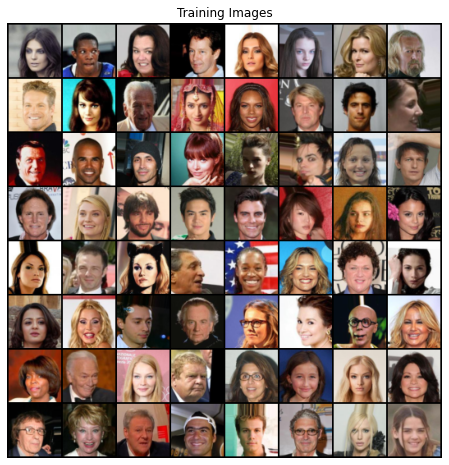

In [4]:
## show some images from dataset
btch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(btch[0].to(device)[:64], padding = 2, normalize=True).cpu(),(1,2,0)))

In [5]:
device

device(type='cuda', index=0)

In [6]:
## create Generator
class Generator(nn.Module):
    def __init__(self):
        # initilization
        super().__init__()
        # convoluation neural network
        self.main = nn.Sequential(
            # 5 layers
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [7]:
# normalize weights in model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
G = Generator().to(device)
G.apply(weights_init)
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
## create Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        # initilization
        super().__init__()
        # convoluation neural network
        self.main = nn.Sequential(
            # 5 layers
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
  
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
D = Discriminator().to(device)
D.apply(weights_init)
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
## loss functions for D and G
criterion_D = nn.BCELoss()
criterion_G = nn.BCELoss()

## Adam optimizers for D and G
D_optimizer = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

## function to create random picture
random_picture = torch.randn(64, 100, 1, 1, device=device)

In [14]:
## train

iters = 0
G_losses = []
D_losses = []
all_images = []



for epoch in range(5):
    for i, data in enumerate(dataloader, 0):
        D.zero_grad()
        item = data[0].to(device)
        i_size = item.size(0)
        label = torch.full((i_size,), 1., dtype=torch.float, device=device)

        output = D(item).view(-1)
        D_err = criterion_D(output, label)
        D_err.backward()


        rand_pic = torch.randn(i_size, 100, 1, 1, device=device)
        fake = G(rand_pic)
        label.fill_(0.)
        
        output = D(fake.detach()).view(-1)
        D_err_for_fake = criterion_D(output, label)
        D_err_for_fake.backward()

        D_err = D_err + D_err_for_fake
        D_optimizer.step()







        G.zero_grad()
        label.fill_(1.)
        output = D(fake).view(-1)

        G_err = criterion_G(output, label)
        G_err.backward()
        G_optimizer.step()
        
        
        G_losses.append(G_err.item())
        D_losses.append(D_err.item())

        if i % 100 == 0:
            print("Epoch №:", epoch, ", percent of batch:", float('{:.2f}'.format(i / len(dataloader))) * 100,
                        ", D loss:", D_err.item(), ", G loss:", G_err.item())
            

        ## append some images to our list
        if (iters % 500 == 0):
            with torch.no_grad():
                fake = G(random_picture).detach().cpu()
            all_images.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Epoch №: 0 , percent of batch: 0.0 , D loss: 0.41657641530036926 , G loss: 24.325572967529297
Epoch №: 0 , percent of batch: 6.0 , D loss: 2.301868200302124 , G loss: 5.292946815490723
Epoch №: 0 , percent of batch: 13.0 , D loss: 0.6255669593811035 , G loss: 7.3501081466674805
Epoch №: 0 , percent of batch: 19.0 , D loss: 0.3677741289138794 , G loss: 3.8626554012298584
Epoch №: 0 , percent of batch: 25.0 , D loss: 0.5004829168319702 , G loss: 4.853051662445068
Epoch №: 0 , percent of batch: 32.0 , D loss: 0.6065582633018494 , G loss: 4.37851095199585
Epoch №: 0 , percent of batch: 38.0 , D loss: 0.42571255564689636 , G loss: 3.9073848724365234
Epoch №: 0 , percent of batch: 44.0 , D loss: 0.27239030599594116 , G loss: 3.1223840713500977
Epoch №: 0 , percent of batch: 51.0 , D loss: 0.5324625968933105 , G loss: 5.255817413330078
Epoch №: 0 , percent of batch: 56.99999999999999 , D loss: 0.7944156527519226 , G loss: 6.872038841247559
Epoch №: 0 , percent of batch: 63.0 , D loss: 0.45788

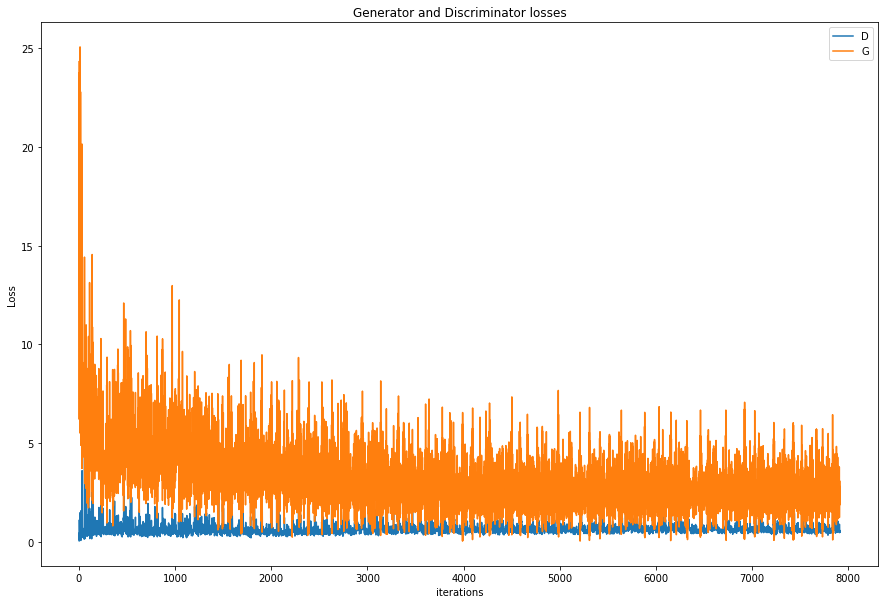

In [18]:
plt.figure(figsize=(15,10))
plt.title("Generator and Discriminator losses")
plt.plot(D_losses,label="D")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
## also we can try increase num of epochs for better result
iters = 0
G_losses = []
D_losses = []
all_images = []



for epoch in range(10):
    for i, data in enumerate(dataloader, 0):
        D.zero_grad()
        item = data[0].to(device)
        i_size = item.size(0)
        label = torch.full((i_size,), 1., dtype=torch.float, device=device)

        output = D(item).view(-1)
        D_err = criterion_D(output, label)
        D_err.backward()


        rand_pic = torch.randn(i_size, 100, 1, 1, device=device)
        fake = G(rand_pic)
        label.fill_(0.)
        
        output = D(fake.detach()).view(-1)
        D_err_for_fake = criterion_D(output, label)
        D_err_for_fake.backward()

        D_err = D_err + D_err_for_fake
        D_optimizer.step()







        G.zero_grad()
        label.fill_(1.)
        output = D(fake).view(-1)

        G_err = criterion_G(output, label)
        G_err.backward()
        G_optimizer.step()
        
        
        G_losses.append(G_err.item())
        D_losses.append(D_err.item())

        if i % 100 == 0:
            print("Epoch №:", epoch, ", percent of batch:", float('{:.2f}'.format(i / len(dataloader))) * 100,
                        ", D loss:", D_err.item(), ", G loss:", G_err.item())
            

        
        ## append some images to our list
        if (iters % 500 == 0):
            with torch.no_grad():
                fake = G(random_picture).detach().cpu()
            all_images.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Generator and Discriminator losses")
plt.plot(D_losses,label="D")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()